In [ ]:
pip install torch==1.6.0 torchvision==0.7.0

Mounted at /content/drive/


Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



stop training, total GAN time(minutes) is:43.33


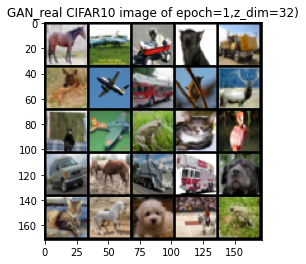

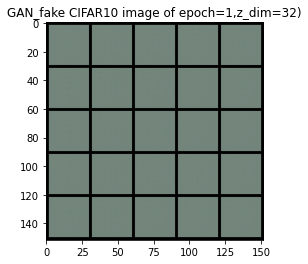

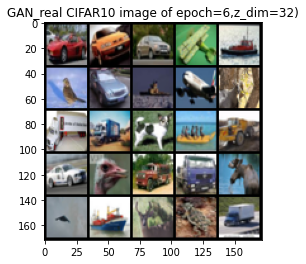

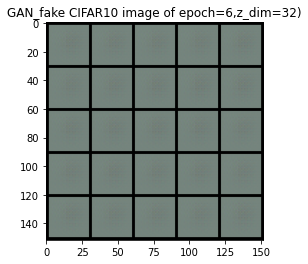

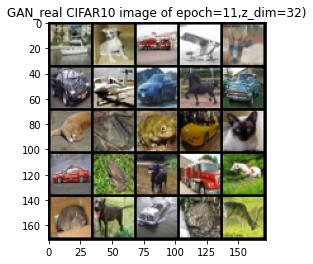

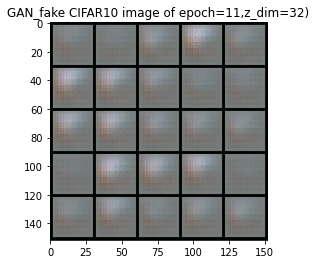

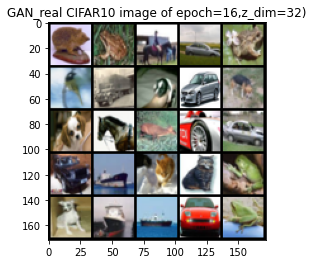

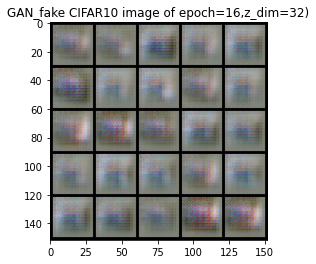

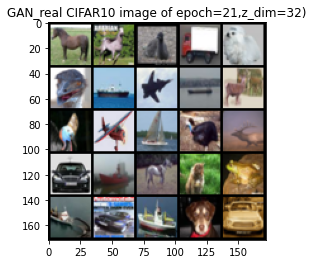

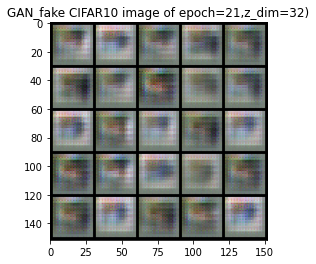

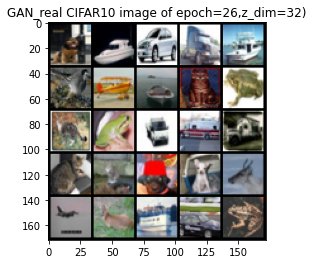

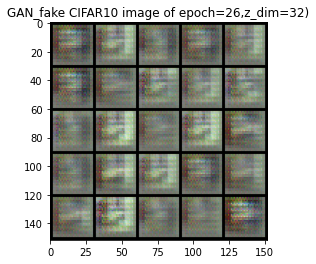

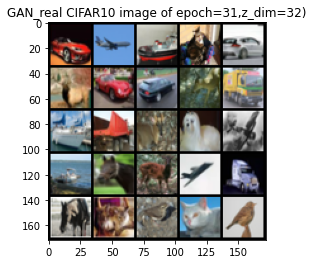

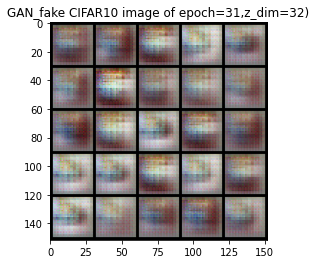

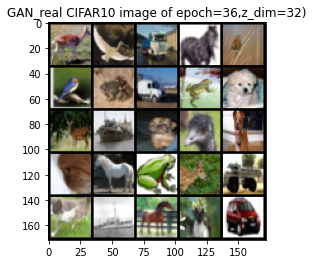

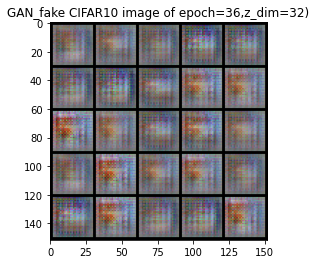

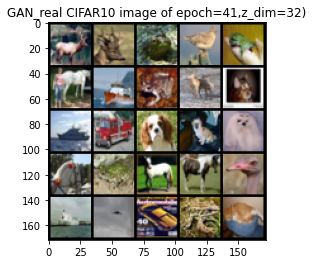

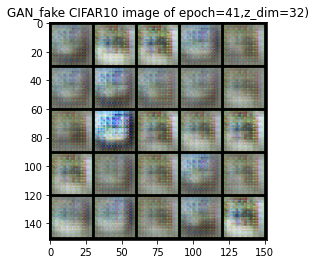

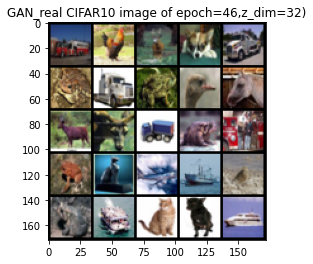

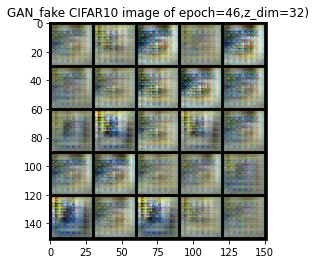

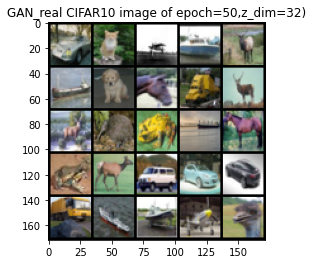

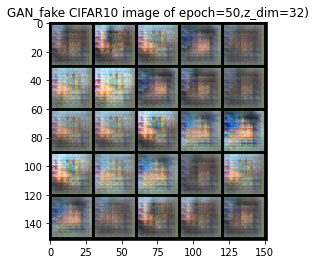

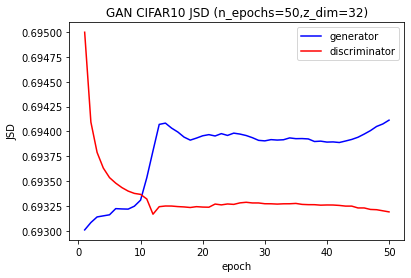

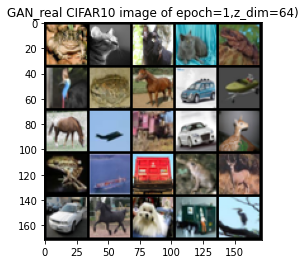

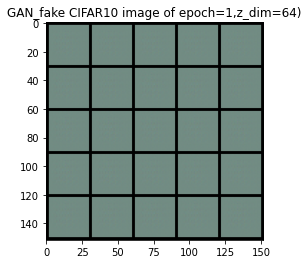

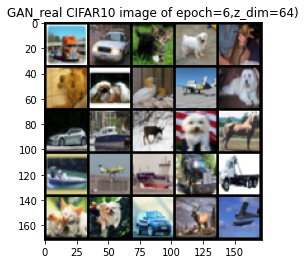

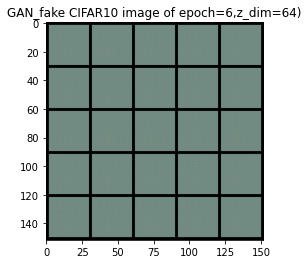

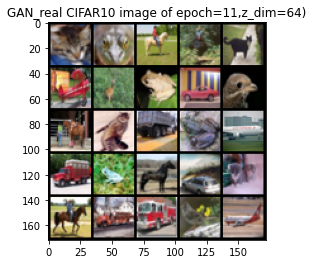

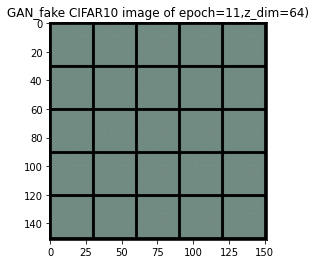

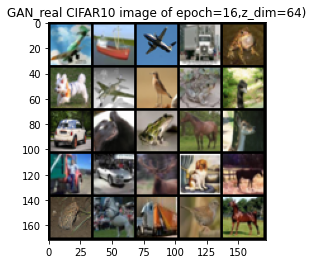

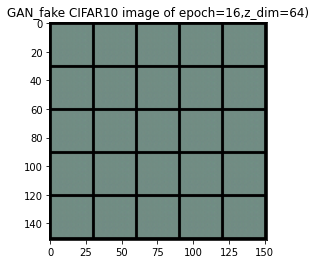

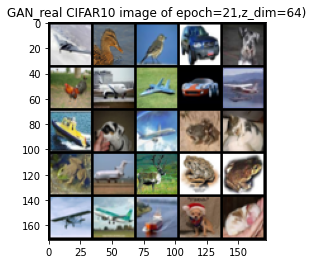

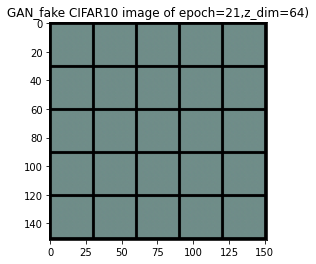

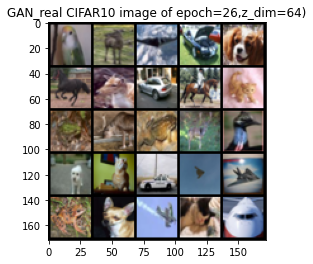

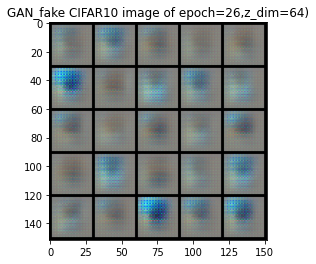

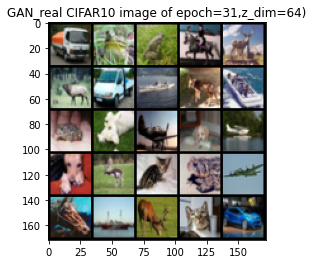

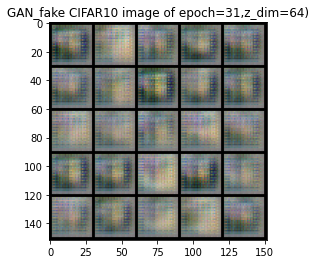

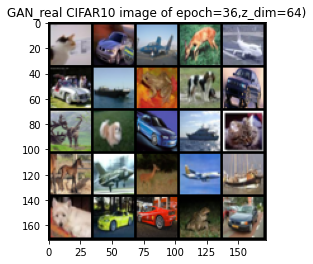

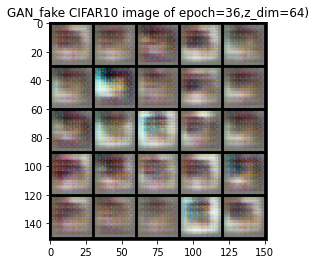

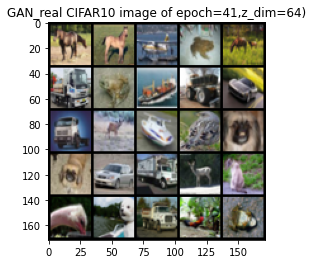

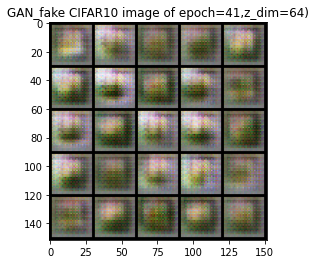

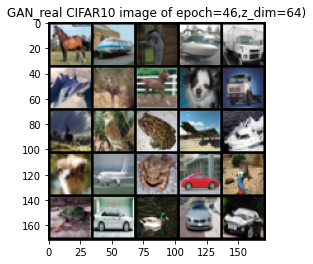

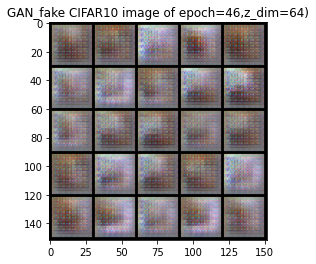

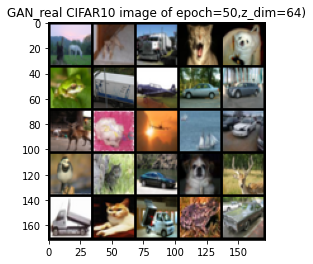

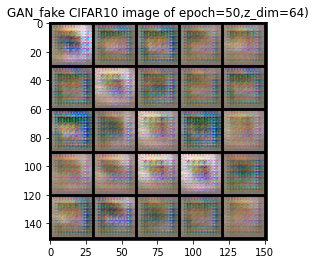

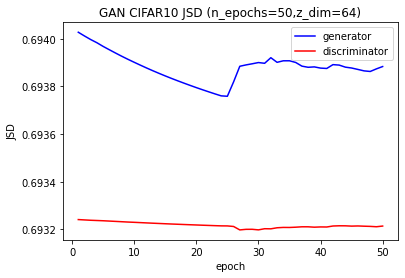

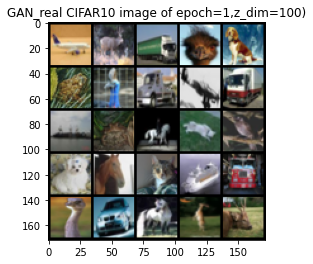

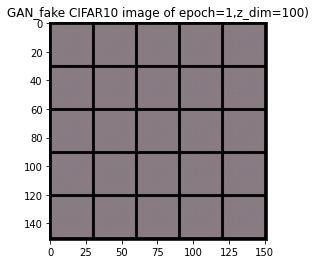

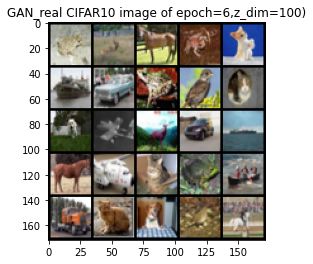

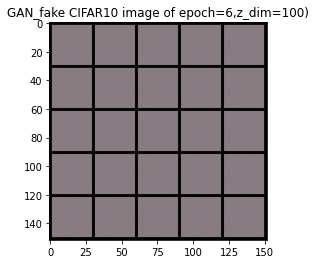

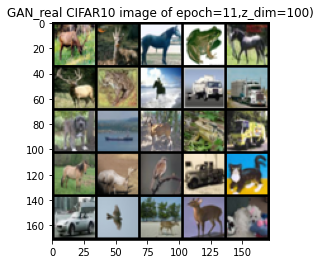

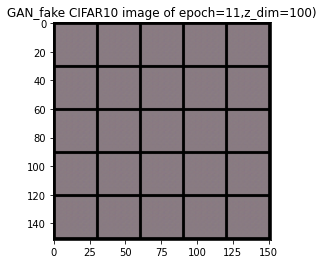

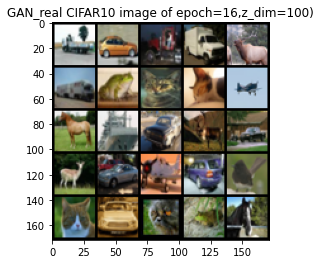

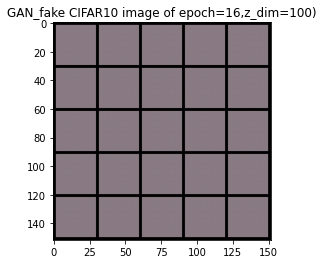

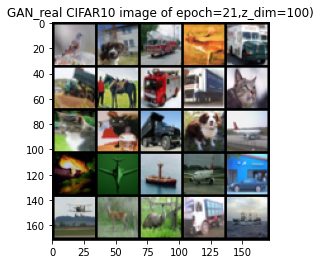

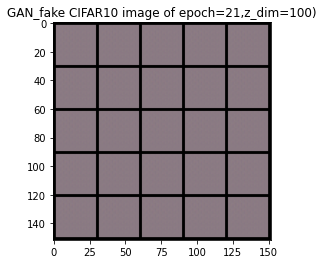

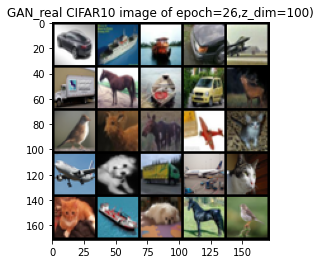

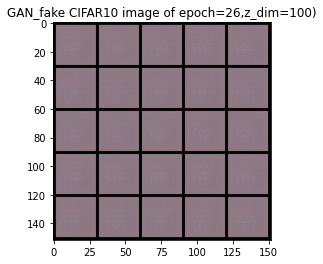

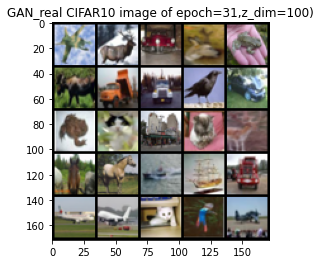

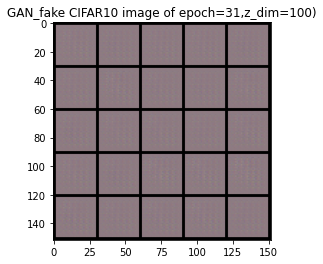

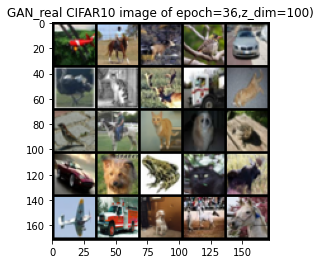

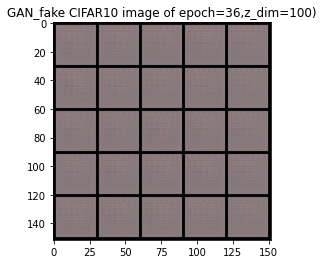

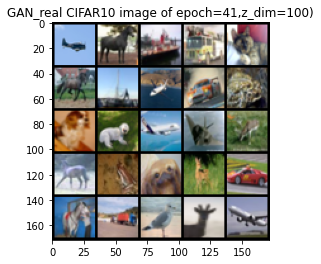

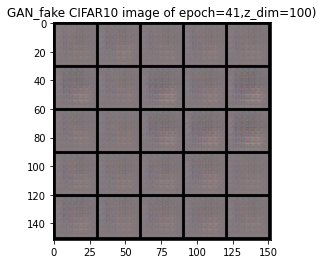

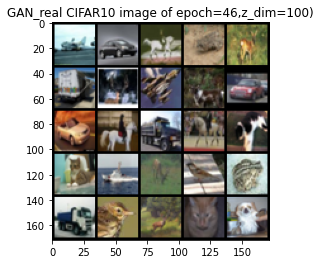

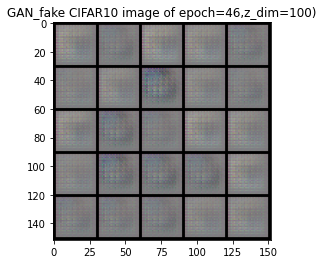

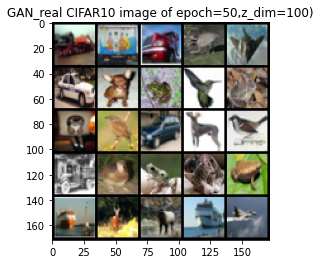

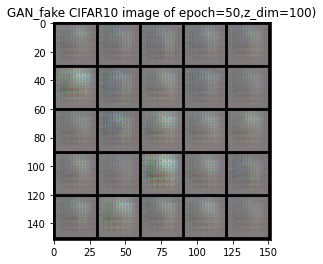

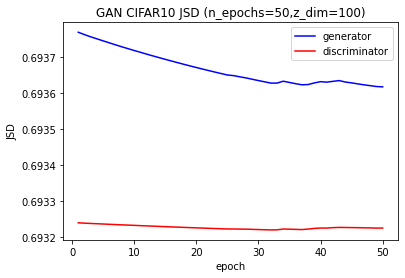

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
from pandas import ExcelWriter
import time
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import drive
drive.mount('/content/drive/')

torch.manual_seed(0)

def show_tensor_images(image_tensor,title,num_images=25,size=(1,32,32)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images],nrow=5)
    plt.figure()
    plt.title(title)
    plt.imshow(image_grid.permute(1,2,0).squeeze())

def multipage(filename,figs=None,dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp,format='pdf')
    pp.close()

class Generator(nn.Module):
    def __init__(self,z_dim=10,im_chan=3,hidden_dim=64):
        super(Generator,self).__init__()
        self.z_dim = z_dim
        self.gen=nn.Sequential(
            self.make_gen_block(z_dim,hidden_dim*4),
            self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            self.make_gen_block(hidden_dim*2,hidden_dim),
            self.make_gen_block(hidden_dim,im_chan,kernel_size=4,final_layer=True)
            )
    def make_gen_block(self,input_channels,output_channels,kernel_size=3,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                                 nn.BatchNorm2d(output_channels),
                                 nn.ReLU(inplace=True))
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh()
                )
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    def forward(self,noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples,z_dim,device):
    return torch.randn(n_samples,z_dim,device=device)

class Discriminator(nn.Module):
    def __init__(self,im_chan=3,hidden_dim=16):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan,hidden_dim),
            self.make_disc_block(hidden_dim,hidden_dim*2),
            self.make_disc_block(hidden_dim*2,1,final_layer=True)
            )
    def make_disc_block(self,input_channels,output_channels,kernel_size=4,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels,output_channels,kernel_size,stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2,inplace=True)
                )
        else:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels,output_channels,kernel_size,stride))
                )
    def forward(self,image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred),-1)

def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)



#Start Training:
start_time = time.time()
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
mean_generator_loss = 0
mean_discriminator_loss = 0
data_list = []
discriminator_loss = 0
generator_loss = 0
mean_generator_loss_list = []
mean_discriminator_loss_list = []
display_step = 1
cur_step = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
dataloader = DataLoader(CIFAR10('.',download=True,transform=transform),batch_size=batch_size,shuffle=True)
criterion=nn.BCEWithLogitsLoss()
n_epochs = 50
z_dims = [32,64,100]
loader_num = 0

for z_dim in z_dims:
    gen = Generator(z_dim).to(device)
    gen_opt=torch.optim.Adam(gen.parameters(),lr=lr,betas=(beta_1,beta_2))
    disc=Discriminator().to(device)
    disc_opt=torch.optim.Adam(disc.parameters(),lr=lr,betas=(beta_1,beta_2))
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

    for epoch in range(n_epochs):
        for real, _ in tqdm(dataloader):
            real = real.to(device)
            disc_opt.zero_grad()
            fake_noise = get_noise(len(real),z_dim,device=device)
            fake = gen(fake_noise)
            disc_fake_pred = disc(fake.detach())
            disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
            disc_real_pred = disc(real)
            disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss)/2 
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
            gen_opt.zero_grad()
            fake_noise_2 = get_noise(len(real),z_dim,device=device)
            fake_2 = gen(fake_noise_2)
            disc_fake_pred = disc(fake_2)
            gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()
            loader_num +=1
            discriminator_loss += disc_loss.item()
            generator_loss += gen_loss.item()

        mean_generator_loss = round(generator_loss,3)/loader_num
        mean_discriminator_loss = round(discriminator_loss,3)/loader_num
        mean_generator_loss_list.append(mean_generator_loss)
        mean_discriminator_loss_list.append(mean_discriminator_loss)
        data_list.append([epoch,z_dim,mean_generator_loss,mean_discriminator_loss])
        #print(f'current_epoch:{epoch+1},generator_loss:{mean_generator_loss}, discriminator loss:{mean_discriminator_loss}')
    
        if epoch%5==0 or epoch+1==n_epochs:
            show_tensor_images(real,'GAN_real CIFAR10 image of epoch='+str(epoch+1)+',z_dim='+str(z_dim)+')')
            show_tensor_images(fake,'GAN_fake CIFAR10 image of epoch='+str(epoch+1)+',z_dim='+str(z_dim)+')')

    plt.figure()
    plt.title('GAN CIFAR10 JSD (n_epochs='+str(n_epochs)+',z_dim='+str(z_dim)+')')
    plt.plot(range(1,n_epochs+1),mean_generator_loss_list,color='blue',label='generator')
    plt.plot(range(1,n_epochs+1),mean_discriminator_loss_list,color='red',label='discriminator')
    plt.xlabel('epoch')
    plt.ylabel('JSD')
    plt.legend()
    mean_generator_loss_list=[]
    mean_discriminator_loss_list=[]

data_df = pd.DataFrame(data_list)
data_df.columns=['epoch','z_dim','generator_loss','discriminator_loss']

multipage('/content/drive/My Drive/GAN_CIFAR10/GAN CIFAR10 record(n_epochs='+str(n_epochs)+',z_dim='+str(z_dim)+')')

with ExcelWriter('/content/drive/My Drive/GAN_CIFAR10/GAN_CIFAR10_output_table.xlsx',engine='openpyxl',mode='a') as writer:
    data_df.to_excel(writer,index=False)
    writer.save()

total_time = time.time()-start_time
total_time = round(total_time/60,2)

with open('/content/drive/My Drive/GAN_CIFAR10/record for GAN CIFAR10.txt','a') as to_file:
    to_file.write('\n')
    to_file.write('GAN CIFAR10 record(n_epochs='+str(n_epochs)+',z_dim='+str(z_dim)+')')
    to_file.write('\n')
    to_file.write('total runing time(minutes) is:'+str(total_time))
    to_file.close()


print(f'stop training, total GAN time(minutes) is:{total_time}')



